In [1]:
from nilearn import image as nimg
from nilearn import plotting 
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_design_matrix
import numpy as np
import decouple
from nilearn.glm.first_level import FirstLevelModel
import scipy.stats as stats
from nilearn.reporting import get_clusters_table
from nilearn.maskers import NiftiSpheresMasker

In [2]:
config = decouple.AutoConfig(' ')
fmriprep_location = config('preprocessed_happy_2')
root_dir = config('raw_data')
img = nimg.load_img(f'{fmriprep_location}/sub-B1001/func/sub-B1001_task-happy_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz') 
confounds_df = pd.read_csv(f'{fmriprep_location}/sub-B1001/func/sub-B1001_task-happy_desc-confounds_timeseries.tsv', sep='\t')
events_df = pd.read_csv(root_dir + f'/bids_t2/sub-B1001/func/sub-B1001_task-happy_events.tsv')

In [3]:
design_matrix = make_first_level_design_matrix(
    confounds_df.index, 
    events_df, 
    hrf_model='spm',
    add_regs=confounds_df[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']],
    drift_model='cosine')

/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `IsCorrect` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in even

<Axes: label='conditions', ylabel='scan number'>

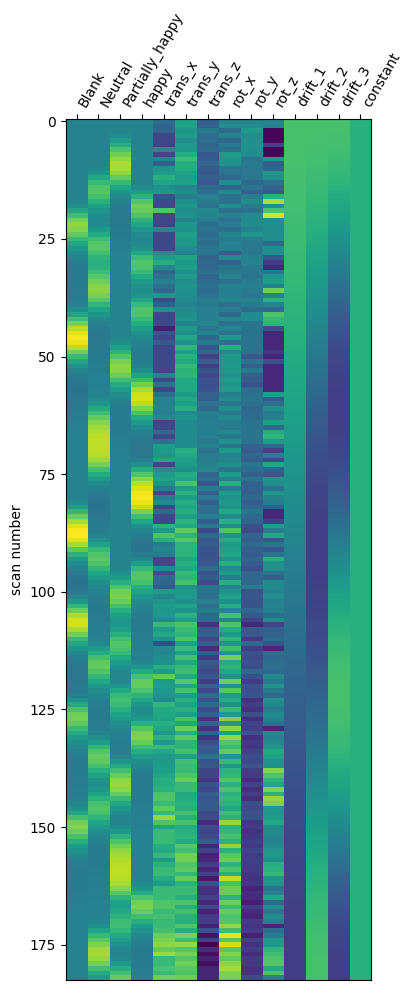

In [4]:
plot_design_matrix(design_matrix)

In [6]:
n_columns = design_matrix.shape[1]
contrast_val = np.hstack(([0, -1, 0, 1,], np.zeros(n_columns - 4)))

In [7]:
fmri_1level = FirstLevelModel(t_r=2, noise_model='ar1', minimize_memory=False)
fmri_1level = fmri_1level.fit(img, design_matrices=design_matrix)
linear_contrasts = fmri_1level.compute_contrast(contrast_val, output_type='all')

In [19]:
fmri_1level.results_[0]['-0.01'].theta

array([[ -1.4541053 ,  -3.42895774,  -1.05086566, ...,   1.43169552,
         -0.86358488,   2.69960107],
       [ -1.51923808,  -3.15609649,  -0.7206318 , ...,   1.21632643,
         -0.91752555,   2.38158806],
       [ -1.13472089,  -2.56417917,  -3.95578141, ...,   0.42055686,
         -0.91192254,   2.84777979],
       ...,
       [ -3.63005652, -11.38695667,   2.6487996 , ...,  -6.6434374 ,
         -3.00872206, -15.18954695],
       [  0.82508082,   1.80940074,  -7.59924955, ...,  -3.85479207,
         -1.18339201,   1.40084193],
       [ -0.52340889,   0.35603182,   1.84743917, ...,  -1.52926228,
         -0.3707167 ,  -4.09870325]])

In [46]:
print(linear_contrasts)

{'z_score': <nibabel.nifti1.Nifti1Image object at 0x7f6826b64970>, 'stat': <nibabel.nifti1.Nifti1Image object at 0x7f6829aa2850>, 'p_value': <nibabel.nifti1.Nifti1Image object at 0x7f6826cbbd30>, 'effect_size': <nibabel.nifti1.Nifti1Image object at 0x7f6826b4a730>, 'effect_variance': <nibabel.nifti1.Nifti1Image object at 0x7f6826ccf310>}


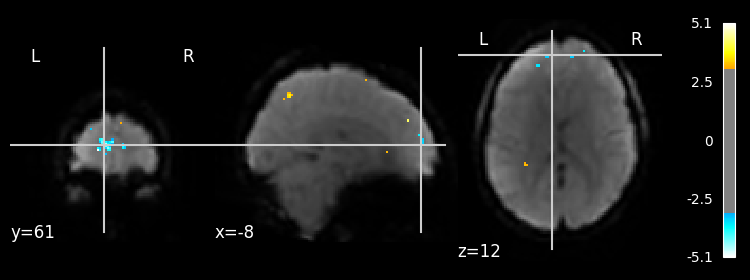

In [47]:
plotting.plot_stat_map(
    linear_contrasts['z_score'],
    bg_img=mean_img, threshold=3.14,
)

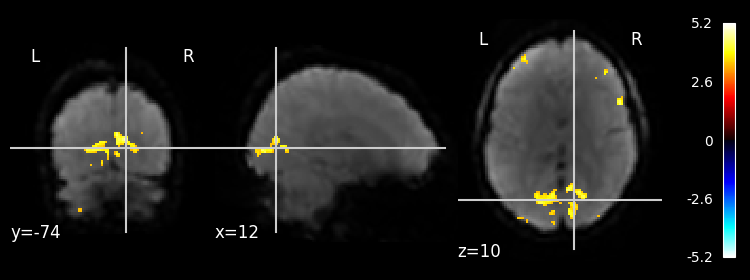

In [48]:
img_prep = nimg.load_img(f'{config("happy")}/1stlevel/results/T2/sub-B1001/spmT_0001.nii') 

thresholded_map1, threshold1 = threshold_stats_img(
    img_prep,
    threshold=3.14,
    alpha=.001,
    height_control='fpr',
    cluster_threshold=0,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map1,
    threshold=0.0,
    bg_img=mean_img,
)


In [51]:
table_1 = get_clusters_table(thresholded_map1, stat_threshold=0.0,
                           cluster_threshold=10.0).set_index('Cluster ID', drop=True)
table_1.head()

,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,-6.5,-68.5,5.5,5.188455,3568
1a,-24.5,-70.5,7.5,4.612998,
1b,-10.5,-84.5,1.5,4.579925,
1c,-16.5,-76.5,11.5,4.366019,
2,35.5,57.5,23.5,4.847658,712


In [25]:
table = get_clusters_table(linear_contrasts['z_score'], stat_threshold=3.1,
                           cluster_threshold=20).set_index('Cluster ID', drop=True)
table.head()

,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,29.5,-36.5,69.5,5.986924,6128
1a,21.5,-46.5,69.5,4.982916,
1b,33.5,-24.5,59.5,4.941097,
1c,35.5,-36.5,67.5,4.931119,
2,19.5,-8.5,63.5,5.217408,1304


In [26]:
coords = table.loc[range(1, 7), ['X', 'Y', 'Z']].values
masker = NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(img)
predicted_timeseries = masker.fit_transform(fmri_1level.predicted[0])

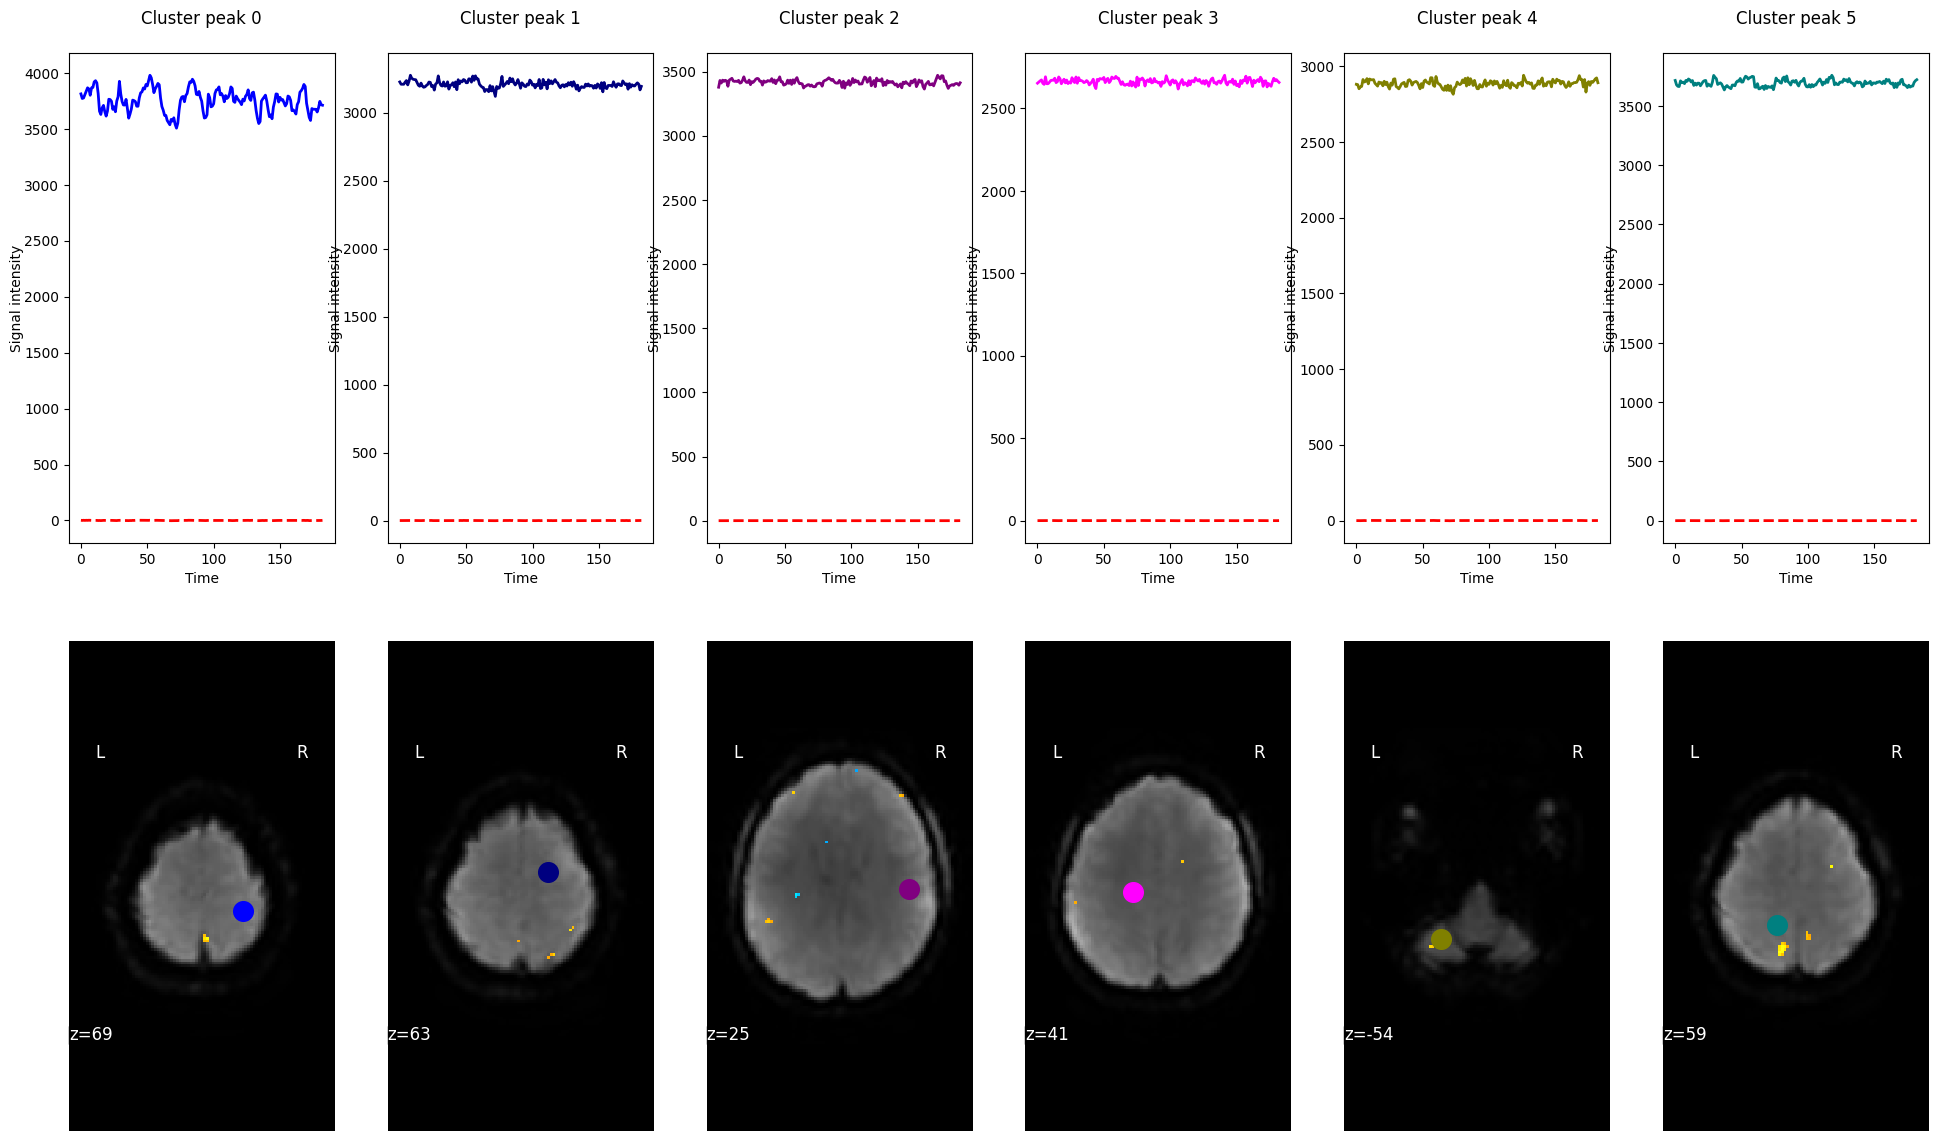

In [49]:
import matplotlib.pyplot as plt

# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta', 'olive', 'teal']
# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 6)
for cluster in range(0, 6):
    # plotting time series
    axs1[0, cluster].set_title(f'Cluster peak {cluster}\n')
    axs1[0, cluster].plot(real_timeseries[:, cluster], c=colors[cluster], lw=2)
    axs1[0, cluster].plot(predicted_timeseries[:, cluster], c='r', ls='--', lw=2)
    axs1[0, cluster].set_xlabel('Time')
    axs1[0, cluster].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        linear_contrasts['z_score'], cut_coords=[coords[cluster][2]], threshold=3.1, figure=fig1,
        axes=axs1[1, cluster], display_mode='z', colorbar=False, bg_img=mean_img)
    roi_img.add_markers([coords[cluster]], colors[cluster], 200)
fig1.set_size_inches(24, 14)

In [15]:
resid = masker.fit_transform(fmri_1level.residuals[0])

In [16]:
resid[0:,].shape[1]

6

In [50]:
for cluster in range(0, resid[0:,].shape[1]):
    statistic, pval = stats.normaltest(resid[0:,cluster])
    print(f'Cluster number {cluster} normaltest pvalue {pval}')

Cluster number 0 normaltest pvalue 0.5725065966421847
Cluster number 1 normaltest pvalue 0.4200016327900965
Cluster number 2 normaltest pvalue 0.3836060962525441
Cluster number 3 normaltest pvalue 0.9549589464685351
Cluster number 4 normaltest pvalue 0.08729465828566885
Cluster number 5 normaltest pvalue 0.9981594637817294


Mean residuals: -0.0034473370081184993
Mean residuals: -4.0143808270025665e-07
Mean residuals: -0.0007950427187357363
Mean residuals: -0.0004888600407548696
Mean residuals: -9.29512613116586e-06
Mean residuals: -0.0022561077493981293


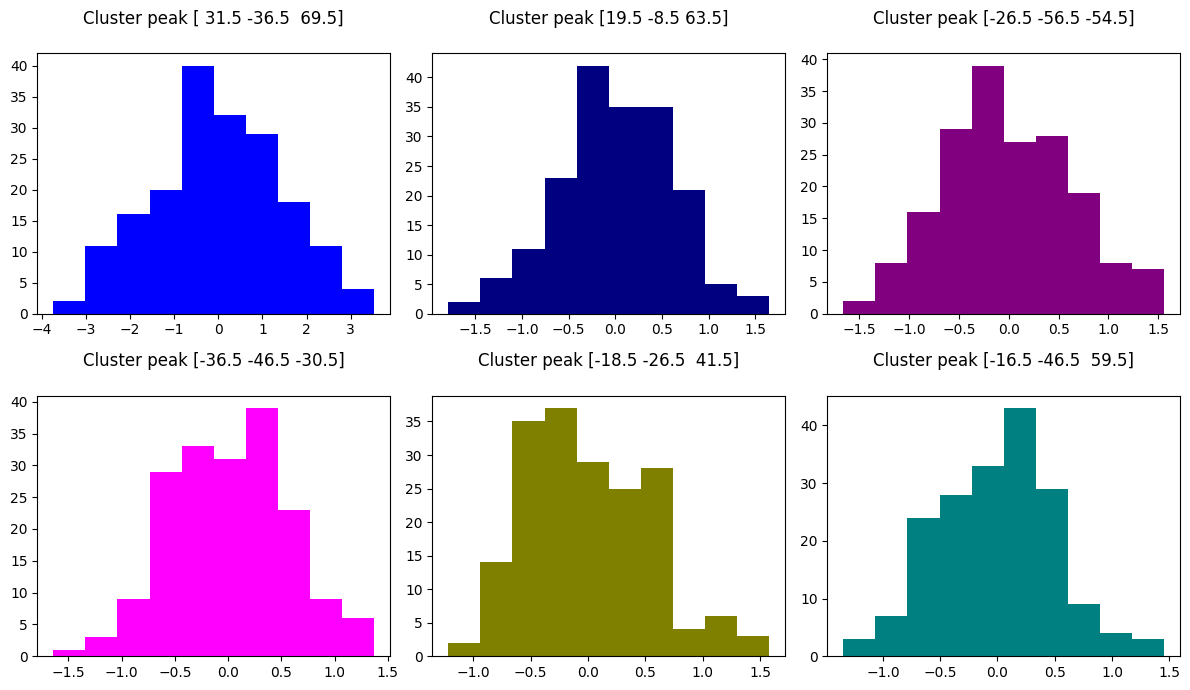

In [18]:
fig2, axs2 = plt.subplots(2, 3)
axs2 = axs2.flatten()
for cluster in range(0, 6):
    axs2[cluster].set_title(f'Cluster peak {coords[cluster]}\n')
    axs2[cluster].hist(resid[:, cluster], color=colors[cluster])
    print(f'Mean residuals: {resid[:, cluster].mean()}')

fig2.set_size_inches(12, 7)
fig2.tight_layout()